
Предлагаем Вам ответить на следующие вопросы:<br>
1) На какие метрики Вы смотрите в ходе анализа и почему?<br>
2) Имеются ли различия в показателях и с чем они могут быть связаны?<br>
3) Являются ли эти различия статистически значимыми?<br>
4) Стоит ли запускать новую механику на всех пользователей?

В качестве входных данных Вы имеете 3 csv-файла:<br>
1) groups.csv : файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе <br>(А'без изменений' – контроль, B 'новая механика' – целевая группа)<br>
2) active_studs.csv : файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.<br>
3) checks.csv:файл с информацией об оплатах пользователей в дни проведения эксперимента.
<br>
<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import norm

Читаем файлы

In [2]:
df_groups = pd.read_csv('/Users/andreygubanov/Desktop/groups.csv', sep=';')
df_active_studs = pd.read_csv('/Users/andreygubanov/Desktop/active_studs.csv', sep=';')
df_checks = pd.read_csv('/Users/andreygubanov/Desktop/checks.csv', sep=';')

Объединяем по id

In [3]:
df_active_studs['actived'] = 1
df_gr_ac = pd.merge(df_groups, df_active_studs.rename(columns={'student_id': 'id'}), how='left', on=['id', 'id'])

In [4]:
df_checks.rename(columns={'student_id': 'id'})
df_merged = pd.merge(df_gr_ac, df_checks.rename(columns={'student_id': 'id'}), how='left', on=['id', 'id'])
df_merged.fillna(0, inplace=True)
df_merged['paying_user'] = df_merged['rev'].map(lambda x: 1 if x > 0 else 0)

df_merged.head() #объединенная таблица

,id,grp,actived,rev,paying_user
0,1206794,B,0.0,0.0,0
1,331024,B,0.0,0.0,0
2,1733498,A,0.0,0.0,0
3,161574,B,0.0,0.0,0
4,168443,B,0.0,0.0,0


Количество пользователей в каждой группе

In [5]:
A_B_counts = df_merged.groupby('grp')['id'].count()
A_B_counts 

grp
A    14693
B    59883
Name: id, dtype: int64

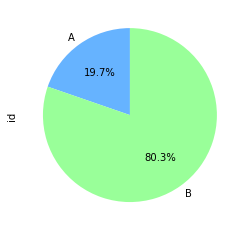

In [6]:
A_B_counts.plot.pie(colors = ['#66b3ff','#99ff99'], autopct='%1.1f%%', startangle=90)

Доля активных пользователей

# На какие метрики Вы смотрите в ходе анализа и почему?


Рассматриваемые метрики для каждой группы среди пользователей посетивших сайт (active_stud) во время эксперимента<br>
    1) Share of active users = all active users / all users                (доля активных пользователей)<br>
    2) CR = all active paying users / all active users      (конверсия)<br>
    3) ARPU = active rev / all active users               (средняя выручка на одного пользователя)<br>
    4) ARPPU = active rev / all active paying users       (средняя выручка на одного платящего пользователя)<br>

In [7]:
df_A = df_merged.loc[df_merged['grp'] == 'A']
df_B = df_merged.loc[df_merged['grp'] == 'B']

In [8]:
# variables for calculating metrics of A group
A_all_users = df_A['actived'].count()
A_all_active_users = df_A['actived'].value_counts()
A_all_active_paying_users = df_A[(df_A['rev'] > 0) & (df_A['actived'] == 1)]['actived'].count()
A_active_rev = df_A[df_A['actived'] == 1]['rev'].sum()


# variables for calculating metrics of B group
B_all_users = df_B['id'].count()
B_all_active_users = df_B['actived'].value_counts()
B_all_active_paying_users = df_B[(df_B['rev'] > 0) & (df_B['actived'] == 1)]['actived'].count()
B_active_rev = df_B[df_B['actived'] == 1]['rev'].sum()

Расчитаем метрики для группы А

In [9]:
A_Share_of_active_users = df_A['actived'].value_counts(normalize=True)
A_CR = A_all_active_paying_users / A_all_active_users[1]
A_ARPU = A_active_rev / A_all_active_users[1]
A_ARPPU = A_active_rev / A_all_active_paying_users
metrics_A = [A_Share_of_active_users[1], A_CR, A_ARPU, A_ARPPU]

Расчитаем метрики для группы B

In [10]:
B_Share_of_active_users = df_B['actived'].value_counts(normalize=True)
B_CR = B_all_active_paying_users / B_all_active_users[1]
B_ARPU = B_active_rev / B_all_active_users[1]
B_ARPPU = B_active_rev / B_all_active_paying_users
metrics_B = [B_Share_of_active_users[1], B_CR, B_ARPU, B_ARPPU]

Покажем все в одной таблице для удобства

In [11]:
names = ['Active users', 'CR', 'ARPU', 'ARPPU']
table = {'Metrics': names, 'A': metrics_A, 'B': metrics_B}
df_ab = pd.DataFrame(table, index=None)
df_ab

,Metrics,A,B
0,Active users,0.104676,0.113605
1,CR,0.050715,0.046156
2,ARPU,47.347204,58.058798
3,ARPPU,933.589744,1257.878992


> Активных пользователей в группе B с новой механикой больше, больше ARPU и ARPPU, но несмотря на это конверсия у нее ниже.<br>
<br>
Это может объясняться тем, что пользователи группы B совершают более дорогие покупки (например, они могли не использовать промокоды при оплате подписки или брали подписку на более продолжительный срок со скидкой и тп)

# Являются ли эти различия статистически значимыми?

In [12]:
from scipy.stats import chi2, chi2_contingency
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from sklearn.utils import resample

H0: доля активности не зависит от группы<br>
<br>

In [13]:
# Shapiro-Wilk Test
# normality test
stat, p = shapiro(df_merged.pivot_table(['id'], ['grp'], ['actived'], aggfunc='count').sort_values('grp'))
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian')
else:
    print('Sample does not look Gaussian')

Statistics=0.807, p=0.116
Sample looks Gaussian


Можем применить критерий Пирсона (chi square)

In [14]:
stat, p, dof, expected = chi2_contingency(df_merged.pivot_table(['id'], ['grp'], ['actived'], aggfunc='count').sort_values('grp'))
print('Выборки для А и B групп соответственно\n', expected, '\n')

# interpret test-statistic
# dof = 1
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability = %.3f, critical = %.3f, stat = %.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

# interpret p-value
alpha = 1.0 - prob
print('significance = %.3f, pvalue = %.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Выборки для А и B групп соответственно
 [[13049.65209987  1643.34790013]
 [53185.34790013  6697.65209987]] 

probability = 0.950, critical = 3.841, stat = 9.380
Dependent (reject H0)
significance = 0.050, pvalue = 0.002
Dependent (reject H0)


> Отвергаем H0. Имеются статистически значимые различия

H0: СR не зависит от группы

In [15]:
# Shapiro-Wilk Test
# normality test
stat, p = shapiro(df_merged[df_merged['actived'] == 1].pivot_table(['id'], ['grp'], ['paying_user'], aggfunc='count').sort_values('grp'))

# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian')
else:
    print('Sample does not look Gaussian')

Sample looks Gaussian


Можем применить критерий Пирсона (chi square)

In [16]:
stat, p, dof, expected = chi2_contingency(df_merged[df_merged['actived'] == 1].pivot_table(['id'], ['grp'], ['paying_user'], aggfunc='count').sort_values('grp'))
print('Выборки для А и B групп соответственно\n', expected, '\n')

# interpret test-statistic
# dof = 1
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability = %.3f, critical = %.3f, stat = %.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

# interpret p-value
alpha = 1.0 - prob
print('significance = %.3f, pvalue = %.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

Выборки для А и B групп соответственно
 [[1465.71897854   72.28102146]
 [6483.28102146  319.71897854]] 

probability = 0.950, critical = 3.841, stat = 0.485
Independent (fail to reject H0)
significance = 0.050, pvalue = 0.486
Independent (fail to reject H0)


> Неотвергаем H0. Не имеются статистически значимые различия

H0: ARPPU и ARPU (оба зависят от одного критерия - выручки) в группах различается статистически значимо

In [17]:
# Shapiro-Wilk Test
# normality test
stat, p = shapiro(df_merged[(df_merged['actived'] == 1) & (df_merged['rev'] > 0) & (df_merged['grp'] == 'A')]['rev'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian')
else:
	print('Sample does not look Gaussian')

Statistics=0.735, p=0.000
Sample does not look Gaussian


In [18]:
# Shapiro-Wilk Test
# normality test
stat, p = shapiro(df_merged[(df_merged['actived'] == 1) & (df_merged['rev'] > 0) & (df_merged['grp'] == 'B')]['rev'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian')
else:
	print('Sample does not look Gaussian')

Statistics=0.855, p=0.000
Sample does not look Gaussian


grp
A    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
B    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

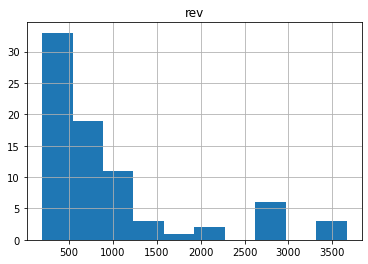

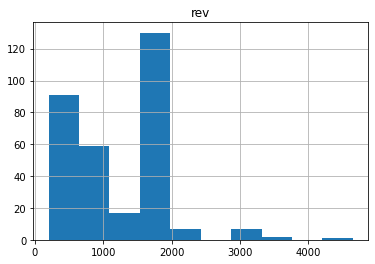

In [19]:
df_merged[(df_merged['rev'] > 0)&(df_merged['actived'] == 1)][['rev', 'grp']].groupby('grp').hist()

Обе выборки распределены не нормально

Используем бутстрап

In [20]:
df_2 = df_merged[(df_merged['rev'] > 0)&(df_merged['actived'] == 1)][['rev', 'grp']]

In [21]:
def bootstrap_ci(df, variable, classes, repetitions = 1000, alpha = 0.05, random_state=None):
  
    df = df[[variable, classes]]
    bootstrap_sample_size = len(df) 
    
    mean_diffs = []

    for i in range(repetitions):
        bootstrap_sample = df.sample(n = bootstrap_sample_size, replace = True, random_state = random_state)
        mean_diff = bootstrap_sample.groupby(classes).mean().iloc[1,0] - bootstrap_sample.groupby(classes).mean().iloc[0,0]
        mean_diffs.append(mean_diff)

    # confidence interval
    left = np.percentile(mean_diffs, alpha/2*100)
    right = np.percentile(mean_diffs, 100-alpha/2*100)

    # point estimate
    point_est = df.groupby(classes).mean().iloc[1,0] - df.groupby(classes).mean().iloc[0,0]

    print('Point estimate of difference between means:', round(point_est,2))
    print((1-alpha)*100,'%','confidence interval for the difference between means:', (round(left,2), round(right,2))) 

In [22]:
bootstrap_ci(df_2, 'rev', 'grp', repetitions = 1000, alpha = 0.05, random_state=None)

Point estimate of difference between means: 324.29
95.0 % confidence interval for the difference between means: (104.65, 535.19)


99.45 не более чем в 2.5% случаев (симметричный интервал) разность средних будет меньше 99.45 <br>
что значит что в 97.5% эта разница больше 99.45.<br>
=>у двух выборок не отличаются средние

>Неотвергаем H0. Не имеются статистически значимые различия. 

# Стоит ли запускать новую механику на всех пользователей?


CR в группе B меньше, но по ходу теста мы показали, что показатель не является статистически значимым.<br>
Другие показатели для группы B больше, и их различия с группой А являются статистически значимыми.
>>Новую механику стоит запускать на всех пользователей